# Quadratic Linear Analysis (QDA)

**Objective**:
 demonstrate how QDA works for classification.

**Assumptions**
- all features are normal distributed.
- all features are uncorrelated
- ~~all classes displays the same covariance matrix~~

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

### Example 1: two predictors with differente correlation matrices

Creating the data

            xA         xB         fx  y
586   2.246981  -6.741174  -4.494193  0
779  21.518940 -15.266398   6.252542  1
322  16.299621  -5.728692  10.570929  1
480  13.925070  -5.884072   8.040998  1
87    1.557341  -6.707773  -5.150432  0


<AxesSubplot:xlabel='value', ylabel='Count'>

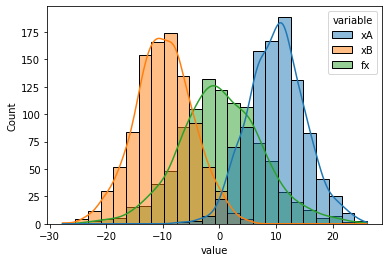

In [2]:
#features X
meanA, stdA = 10, 5
xA = np.random.normal(meanA, stdA, 1000)

meanB, stdB = -10, 5
xB = np.random.normal(meanB, stdB, 1000)

#target y
fx = xA + xB
y = [1 if i >= (meanA + meanB) else 0 for i in fx]

#data with X an y
data = pd.DataFrame({'xA':xA, 'xB':xB, 'fx': fx, 'y':y})
print(data.sample(5))

sns.histplot(data=pd.melt(data, id_vars=['y'], value_vars=['xA', 'xB', 'fx']), x='value', hue='variable', kde=True)

Checking the covariance matrices

In [3]:
#separing the data
sample0 = data.loc[data['y'] == 0]
sample1 = data.loc[data['y'] == 1]
assert data.shape[0] == sample0.shape[0] + sample1.shape[0]

#calculating the covariance matrices
print(sample0[['xA', 'xB']].cov())
print(sample1[['xA', 'xB']].cov())

           xA         xB
xA  16.433043  -7.405066
xB  -7.405066  17.508346
           xA         xB
xA  17.299124  -6.098108
xB  -6.098108  17.594789


The results above shows the differente between the covariance matrices, which is an indication that QDA should be a better suggestion. Since the QDA's decision function is a curve, it would allow more flexibility than the LDA's decision function, which is a straight line, thus resulting in lower bias.

QDA's decision function:

<img src="img/qda_decision_function.PNG" />

*source: https://www.statlearning.com/*

In [4]:
def preparation(df):
    '''calculate every variable (except x and xt) necessary for the decision equation'''

    sample0 = data.loc[data['y'] == 0]
    sample1 = data.loc[data['y'] == 1]

    m0 = sample0[['xA','xB']].mean().array.reshape(2,1)
    m0_t = sample0[['xA','xB']].mean().array
    m1 = sample1[['xA','xB']].mean().array.reshape(2,1)
    m1_t = sample1[['xA','xB']].mean().array

    cov0 = sample0[['xA', 'xB']].cov().to_numpy()
    cov0_inv = np.linalg.inv(sample0[['xA', 'xB']].cov())
    cov1 = sample1[['xA', 'xB']].cov().to_numpy()
    cov1_inv = np.linalg.inv(sample1[['xA', 'xB']].cov())

    ln0, ln1 = np.linalg.det(cov0), np.linalg.det(cov1)
    prob0, prob1 = (sample0.shape[0]/data.shape[0]), (sample1.shape[0]/data.shape[0])

    return m0, m0_t, m1, m1_t, cov0_inv, cov1_inv, ln0, ln1, prob0, prob1


#calculating each variable of the equation
m0, m0_t, m1, m1_t, cov0_inv, cov1_inv, ln0, ln1, prob0, prob1 = preparation(data)

In [5]:
def decision_function(x, x_t, m, m_t, cov_inv, ln, prob):
    '''create the function for each row'''
    fx = -0.5 * np.matmul(np.matmul(x_t, cov_inv), x) + \
              + np.matmul(np.matmul(x_t, cov_inv), m) + \
         -0.5 * np.matmul(np.matmul(m_t, cov_inv), m) + \
         -0.5 * ln + prob               
    return fx[0]


#calculating the decision function
data['fx0'] = np.nan
data['fx1'] = np.nan
data['qda_prediction'] = np.nan

for index, row in data.iterrows():
    x_t = data[['xA','xB']].loc[index].array
    x = data[['xA','xB']].loc[index].array.reshape(2,1)

    data.loc[index, 'fx0'] = decision_function(x, x_t, m0, m0_t, cov0_inv, ln0, prob0)
    data.loc[index, 'fx1'] = decision_function(x, x_t, m1, m1_t, cov1_inv, ln1, prob1)
    data['qda_prediction'] = np.where(data['fx1'] >= data['fx0'], 1, 0)

data

,xA,xB,fx,y,fx0,fx1,qda_prediction
0,8.324456,1.871568,10.196024,1,-123.978713,-135.334297,0
1,5.777577,-5.662278,0.115299,1,-117.448432,-134.617707,0
2,6.891542,-5.211345,1.680197,1,-117.843272,-134.145836,0
3,3.513287,-0.002168,3.511119,1,-120.667119,-136.044842,0
4,16.324454,-8.942814,7.381639,1,-120.584477,-133.462459,0
...,...,...,...,...,...,...,...
995,3.037320,-22.204443,-19.167124,0,-121.072226,-147.389965,0
996,12.647420,-4.503826,8.143594,1,-120.796314,-133.262829,0
997,9.027095,-15.390879,-6.363785,0,-116.150529,-136.708540,0
998,9.935817,-13.521981,-3.586164,0,-116.151444,-135.279691,0


In [8]:
#comparing the results
print(confusion_matrix(data['y'], data['qda_prediction']))
print(accuracy_score(data['y'], data['qda_prediction']))
print(precision_score(data['y'], data['qda_prediction']))
print(recall_score(data['y'], data['qda_prediction']))

[[503   0]
 [497   0]]
0.503
0.0
0.0


C:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Something is wrong with the formula. Doing some investigation.